# Problem 1

Code up a 2-class kernel nearest mean classifier that can use RBF or linear classifier.

In [9]:
#!/usr/bin/env python
# coding: utf-8

##################################################
# Author:   Sarthak Kumar Maharana
# Email:    maharana@usc.edu
# Date:     03/11/2022
# Course:   EE 559
# Project:  Midterm 
# Instructor: Prof. B Keith Jenkins
##################################################


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Kernel:
    def __init__(self, 
                root, 
                train, 
                test,
                val,
                dataset):
        self.train_file = os.path.join(root, train)
        self.val_file = os.path.join(root, val)
        self.test_file = os.path.join(root, test)
        self.curr_dataset = dataset
        self.labels = [1.0, 2.0] if self.curr_dataset == 'dataset1' else [0.0, 1.0]

    def _get_features(self, path):
        """
        Get features from the data set.

        Parameters
        ----------
        path : str
            path to the data set

        Returns
        -------
        x : np.array
            features
        y : np.array
            labels
        """
        df = pd.read_csv(path, header = None)
        x, y = df.iloc[:, :-1].values.astype(float),\
               df.iloc[:, -1].values.astype(float)
        return x, y

    def _get_data(self):
        """
        Load the data sets (train, validation, and test).

        Parameters
        ----------
        None

        Returns
        -------
        x_train : np.array
            features of training set
        y_train : np.array
            labels of training set
        x_test : np.array
            features of test set
        y_test : np.array
            labels of test set
        """
        self.train_x, self.train_y = self._get_features(self.train_file)
        self.test_x, self.test_y = self._get_features(self.test_file)
        self.val_x, self.val_y = self._get_features(self.val_file)
        return self.train_x, self.train_y, self.val_x, self.val_y, \
               self.test_x, self.test_y

    def _plot_feature_space(self, x, y):
        """
        Visualize the original feature space.

        Parameters
        ----------
        x : ndarray
            Feature matrix of dimension N x D.
        y : ndarray
            Labels of dimension N x 1.

        Returns
        -------
        None
        """
        class_names = ['Class ' + str(int(c)) for c in np.unique(y)]
        classes = np.unique(y)
        style = ['rx', 'bo']
        for idx in range(len(classes)):
            plt.plot(x[y == classes[idx], 0],
                    x[y == classes[idx], 1],
                    style[idx],
                    label = class_names[idx])
        plt.legend(loc = 'upper right')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Feature space (non-augmented)')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def _rbf(x1, x2, gamma = 0.01):
        """
        Implement the rbf kernel.
        
        Parameters
        ----------
        x1: data point 1
            ndarray
        x2: data point 2
            ndarray
        gamma: parameter
            float
            
        Returns
        -------
            : rbf kernel (np.exp(-gamma*L2dist))
            float
        """
        L2dist = np.sqrt(np.sum((x1 - x2)**2))
        return np.exp(-gamma * L2dist)

    @staticmethod
    def _linear_kernel(x1, x2):
        """
        Implement the linear kernel.
        
        Parameters
        ----------
        x1: data point 1
            ndarray
        x2: data point 2
            ndarray
            
        Returns
        -------
            : linear kernel(x1.T * x2)
            float
        
        """
        return np.dot(x1.T, x2)

    def _fit_term1(self, x, y, gamma = None):
        """
        Implement the first term of the dual representation g(k)
        
        Parameters
        ----------
        x: training features 
            ndarray
        y: training labels
            ndarray
        gamma: None (if linear) or float (if rbf)
              
        Returns
        -------
        [term_1_1, term_1_2] : list 
            first term of both the classes
        """
        for curr_class in self.labels:
            curr_x = x[y == curr_class]
            outer_prod_store_1 = 0.0
            for idx in range(len(curr_x)):
                prod_store = 0.0
                for jdx in range(len(curr_x)):
                    if gamma:
                        prod_store += self._rbf(curr_x[idx], curr_x[jdx], gamma)
                    else:
                        prod_store += self._linear_kernel(curr_x[idx], curr_x[jdx])
                outer_prod_store_1 += (prod_store)
            if curr_class == self.labels[0]:
                term_1_1 = -outer_prod_store_1 / (len(x[y == self.labels[0]]) ** 2) 
            else:
                term_1_2 = -outer_prod_store_1 / (len(x[y == self.labels[1]]) ** 2) 
        return [term_1_1, term_1_2]

    def _fit_term2(self, curr_data, x, y, gamma = None):
        """
        Implement the second term of the dual representation g(k)
        
        Parameters
        ----------
        curr_data: data point under consideration (train/test/val)
            ndarray
        x: training features 
            ndarray
        y: training labels
            ndarray
        gamma: None (if linear) or float (if rbf)
              
        Returns
        -------
        [term_2_1, term_2_2] : list 
            second term of both the classes
        """
        for curr_class in self.labels:
            curr_x = x[y == curr_class]
            outer_prod_store_2 = 0.0
            for idx in range(len(curr_x)):
                if gamma:
                    outer_prod_store_2 += self._rbf(curr_x[idx], curr_data, gamma)
                else:
                    outer_prod_store_2 += self._linear_kernel(curr_x[idx], curr_data)
            if curr_class == self.labels[0]:
                term_2_1 = (2 / len(x[y == self.labels[0]])) * outer_prod_store_2
            else:
                term_2_2 = (2 / len(x[y == self.labels[1]])) * outer_prod_store_2  
        return [term_2_1, term_2_2]

    def _g_x(self, kernel_term1, x, gamma = None):
        """
        Implement the final discriminant function for both the classes
        
        kernel_term1: float 
            Implement the first term of the dual representation g(k)
        x: ndarray
            data point under consideration (train/test/val)
        gamma: None (if linear) or float (if rbf)
        
        Returns
        -------
            :ndarray
            g_x of both the classes   
        """
        kernel_term2 = self._fit_term2(x, self.train_x, self.train_y, gamma)
        g_x_1 = np.dot(x.T, x) - (kernel_term1[0] + kernel_term2[0])
        g_x_2 = np.dot(x.T, x) - (kernel_term1[1] + kernel_term2[1])
        return np.array([g_x_1, g_x_2])

    def _optimal_gamma(self, x, y):
        """
        To find the optimal gamma.
        
        Parameters
        ----------
        x: ndarray
            validation features
            
        y: ndarray
            validation labels    
        
        Returns
        -------
        val_k_error: list 
            (k, validation error)
        """
        val_k_error = []
        for k in np.linspace(-2, 2, 100):
            gamma = (10**k)
            error = 0.0
            kernel_term1 = self._fit_term1(self.train_x, self.train_y, gamma)
            for idx in range(len(x)):
                g_x = self._g_x(kernel_term1, x[idx], gamma)
                if g_x[0] > g_x[1] and y[idx] == self.labels[0]:
                    error += 1
                if g_x[0] < g_x[1] and y[idx] == self.labels[1]:
                    error += 1
            val_k_error.append((k , error / len(x)))
        return val_k_error

    def _classify(self, x, y, opt_gamma = None):
        """
        Perform classifications
        
        Parameters
        ----------
        x: ndarray
            features (train/val/test) 
        y: ndarray
            labels (traion/val/test)
        opt_gamma: None if linear float if rbf
        
        Returns
        -------
        error/len(x) : float
            total classification error
        predictions: list
            predictions on x
        """
        predictions, error= [], 0.0
        kernel_term1 = self._fit_term1(self.train_x, self.train_y, opt_gamma)
        for idx in range(len(x)):
            g_x = self._g_x(kernel_term1, x[idx], opt_gamma)
            if g_x[0] > g_x[1] and y[idx] == self.labels[0]:
                error += 1
            if g_x[0] < g_x[1] and y[idx] == self.labels[1]:
                error += 1            
            preds = np.argmin(g_x, axis = 0 ) + 1.0 if self.curr_dataset == 'dataset1'\
                    else np.argmin(g_x, axis = 0)
            predictions.append(preds)
        return error / len(x), predictions

    def _plot_k_errors(self, dataset_k_error):
        """
        Plot validation-loss vs k curve
        
        Parameters
        ----------
        dataset_k_error: list
            (k, losses)
        
        Returns
        -------
        None
        """
        plt.plot([x[0] for x in dataset_k_error], [x[1] for x in dataset_k_error])
        plt.ylabel('Validation error')
        plt.xlabel('k (gamma = 10 ^ k)')
        plt.tick_params(axis = "x")
        plt.tick_params(axis = "y")
        plt.title(f'Validation error vs k (gamma = 10 ^ k) for {self.curr_dataset}')
        plt.tight_layout()
        plt.show()
    
    def _plotter(self, x_data, y_data, opt_gamma = None, kernel = None):
        # Find max and min values of both the features         
        max_x, min_x = np.ceil(max(x_data[:, 0])) + 1, np.floor(min(x_data[:, 0])) - 1
        max_y, min_y = np.ceil(max(x_data[:, 1])) + 1, np.floor(min(x_data[:, 1])) - 1

        inc = 0.05
        # Calculate the range of values for x and y
        range_x = np.arange(min_x, max_x + inc/100, inc)
        range_y = np.arange(min_y, max_y + inc/100, inc)

        # Create a mesh grid of values
        xx, yy = np.meshgrid(range_x, range_y)

        # Predict the values on the mesh grid
        _, grid_preds = np.array(self._classify(np.c_[xx.ravel(), \
                     yy.ravel()], yy.ravel(), opt_gamma))
        preds = np.array(grid_preds).reshape(xx.shape) # matrix of classifications

        # Obtain data points of both the features
        x_1, x_2 = x_data[:,0], x_data[:,1]
        
        _, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 200)

        # Plot the filled contours (decision regions)
        ax.contourf(xx, yy, preds, alpha = 0.25)
        # Plot the decision boundary.
        ax.contour(xx, yy, preds, colors = 'k', linewidths = 0.8, linestyles = 'dashed')
        # Plot the data points (scatter plot)
        ax.scatter(x_1, x_2, c = y_data, edgecolors = 'k')

        ax.grid(False)
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        if opt_gamma:
            ax.set_title(f'Feature space w/ decision boundary and regions of {self.curr_dataset} using the {kernel} kernel with gamma = {opt_gamma}')
        else:
            ax.set_title(f'Feature space w/ decision boundary and regions of {self.curr_dataset} using the {kernel} kernel')   
        # plt.savefig(f'{self.curr_dataset}_{mode}.png')
        plt.tight_layout()
        plt.show()

    def _runner(self):
        """
        Runner file for script.
        """
        print(f'*** RUNNING SCRIPTS FOR {str(self.curr_dataset)} ***')
        self.train_x, self.train_y, self.val_x, self.val_y, self.test_x, self.test_y = self._get_data()

        # 1(d)
        k_errors = self._optimal_gamma(self.val_x, self.val_y)

        # 1(e)
        optimal_k = k_errors[np.argmin([x[1] for x in k_errors])][0]
        print(f'Optimal gamma = {10 ** optimal_k}')
        self._plot_k_errors(k_errors)
        
        # 1(f)
        rbf_error, _ = self._classify(self.test_x, self.test_y, 10 ** optimal_k)
        linear_error, _ = self._classify(self.test_x, self.test_y)
        print(f'Test set error using the RBF and linear kernels = {rbf_error}, {linear_error}, respectively')

        # 1(g)
        print(f"*** Plotting the decision regions for the linear kernel ***")
        self._plotter(self.train_x, self.train_y, kernel = 'linear')

        # 1(h)
        print(f"*** Plotting the decision regions for the RBF kernel ***")
        self._plotter(self.train_x, self.train_y, 10 ** optimal_k, kernel = 'rbf')

        # 1(i)
        for new_gamma_step in [0.01, 0.1, 0.3, 3, 10, 100]:
            print(f"*** Plotting the decision regions for the RBF kernel with gamma = {new_gamma_step * (10**optimal_k)} ***")
            gamma = new_gamma_step * (10**optimal_k)
            self._plotter(self.train_x, self.train_y, gamma, kernel = 'rbf')

        print(f'*** DONE RUNNING SCRIPTS FOR {str(self.curr_dataset)} ***')
       



*** RUNNING SCRIPTS FOR dataset1 ***
Optimal gamma = 1.149756995397737


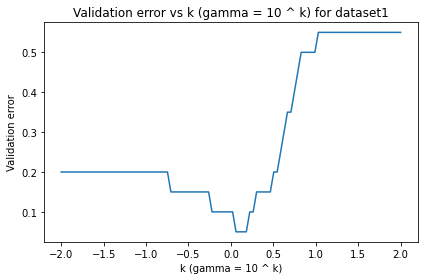

Test set error using the RBF and linear kernels = 0.23, 0.43, respectively
*** Plotting the decision regions for the linear kernel ***


<ipython-input-3-13fe7b1e2fb3>:337: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _, grid_preds = np.array(self._classify(np.c_[xx.ravel(), \


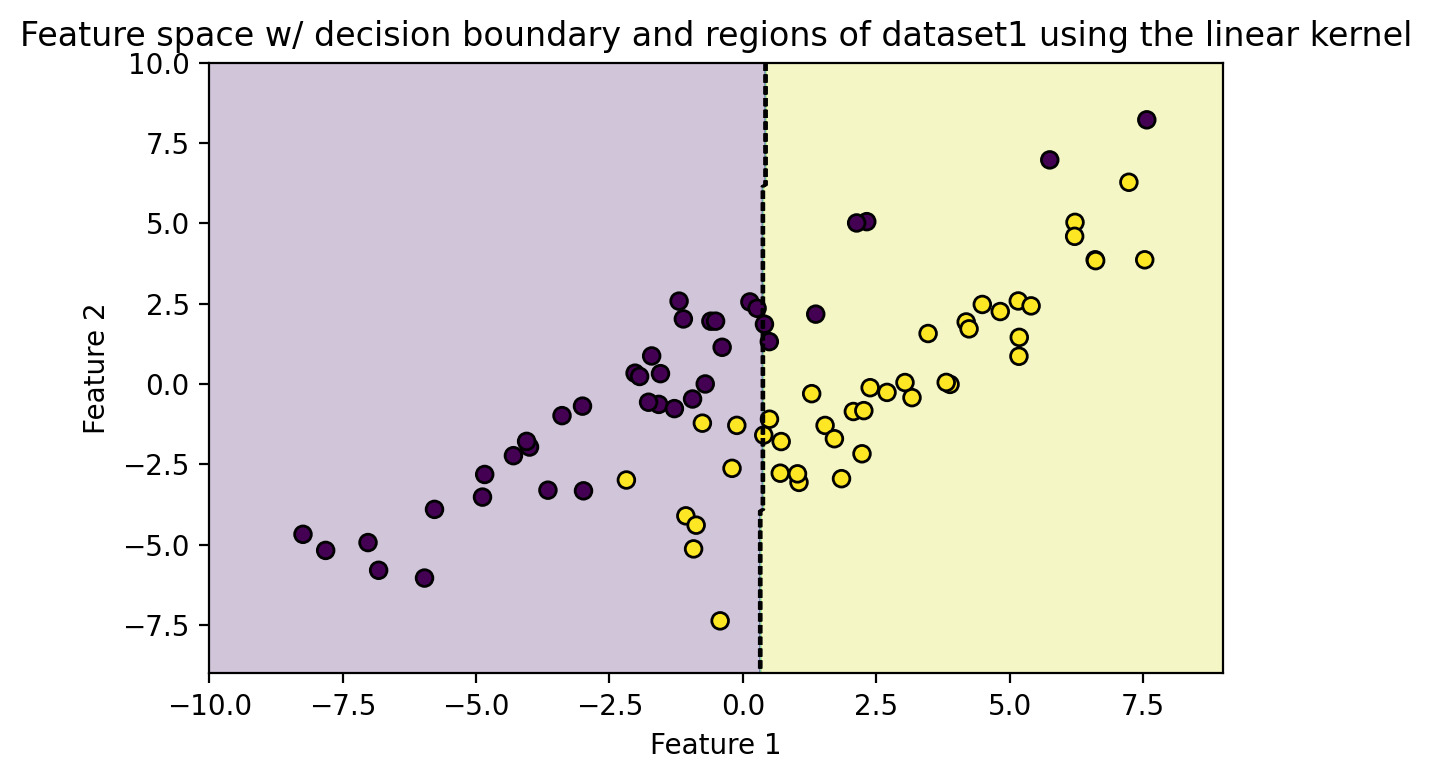

*** Plotting the decision regions for the RBF kernel ***


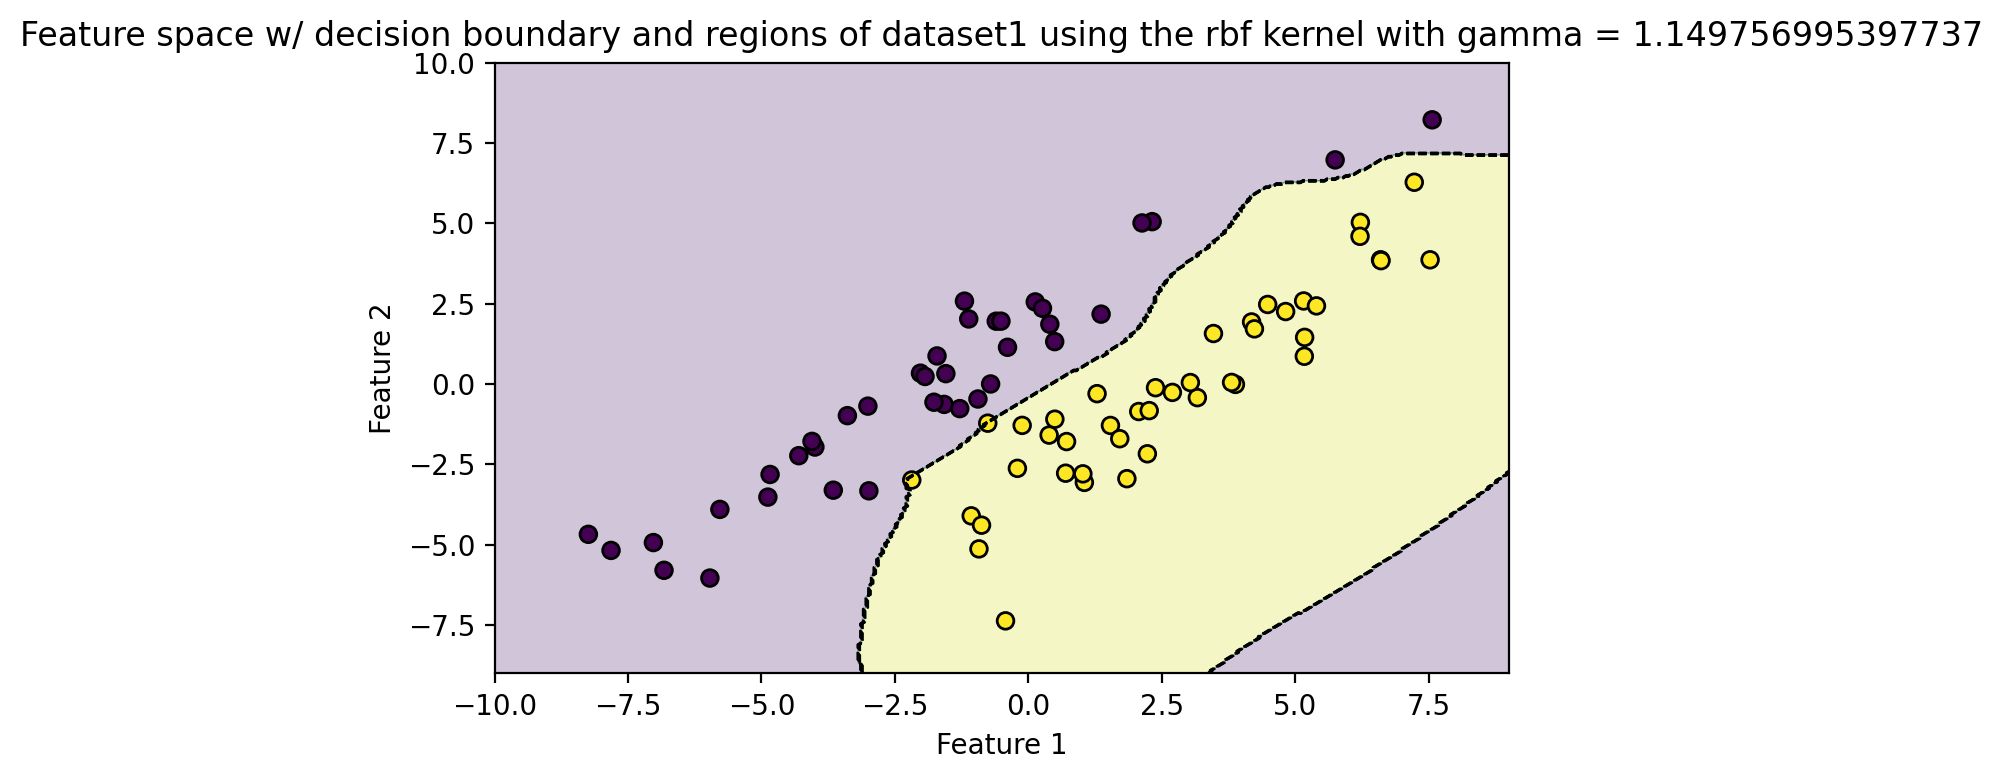

*** Plotting the decision regions for the RBF kernel with gamma = 0.011497569953977368 ***


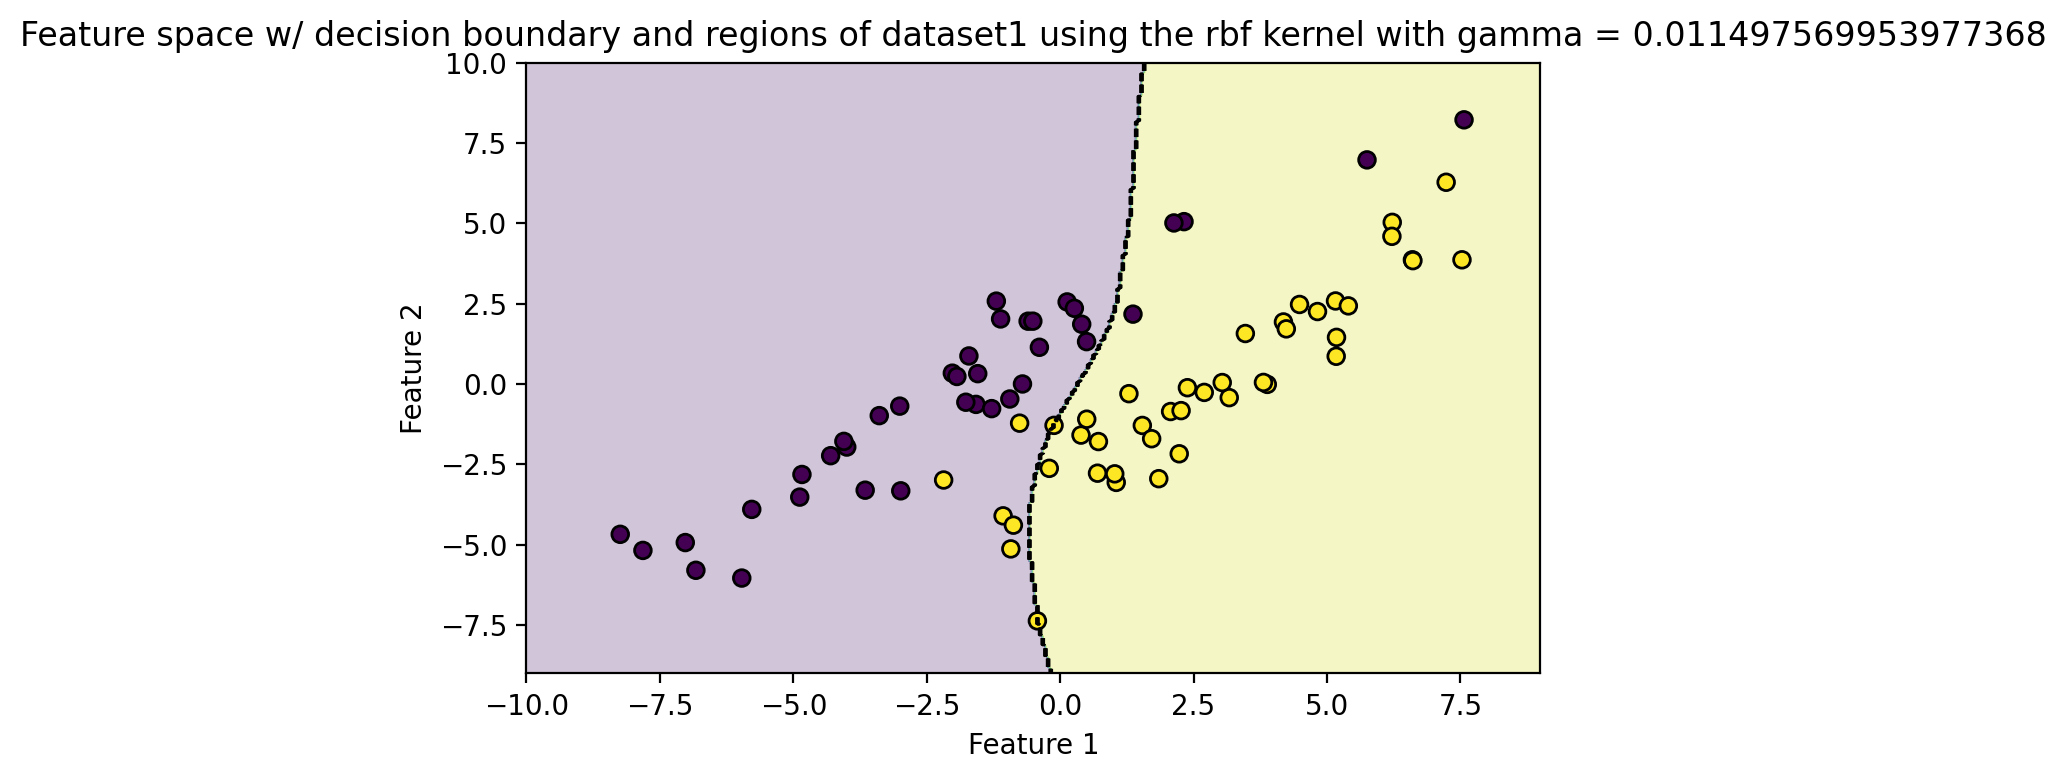

*** Plotting the decision regions for the RBF kernel with gamma = 0.1149756995397737 ***


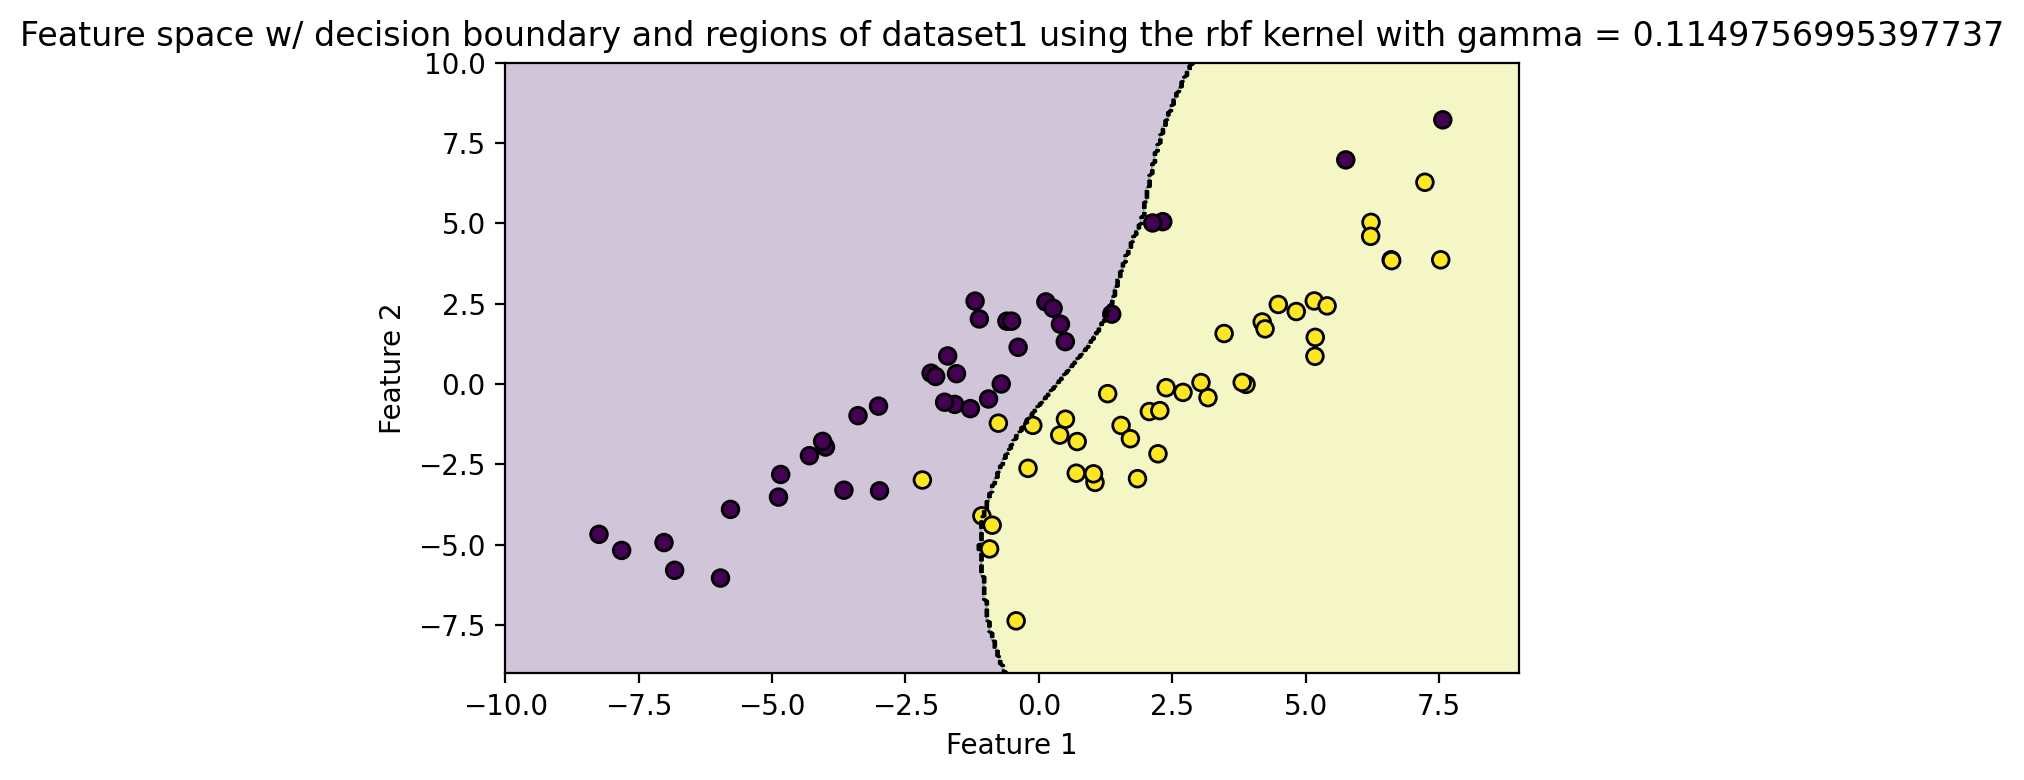

*** Plotting the decision regions for the RBF kernel with gamma = 0.3449270986193211 ***


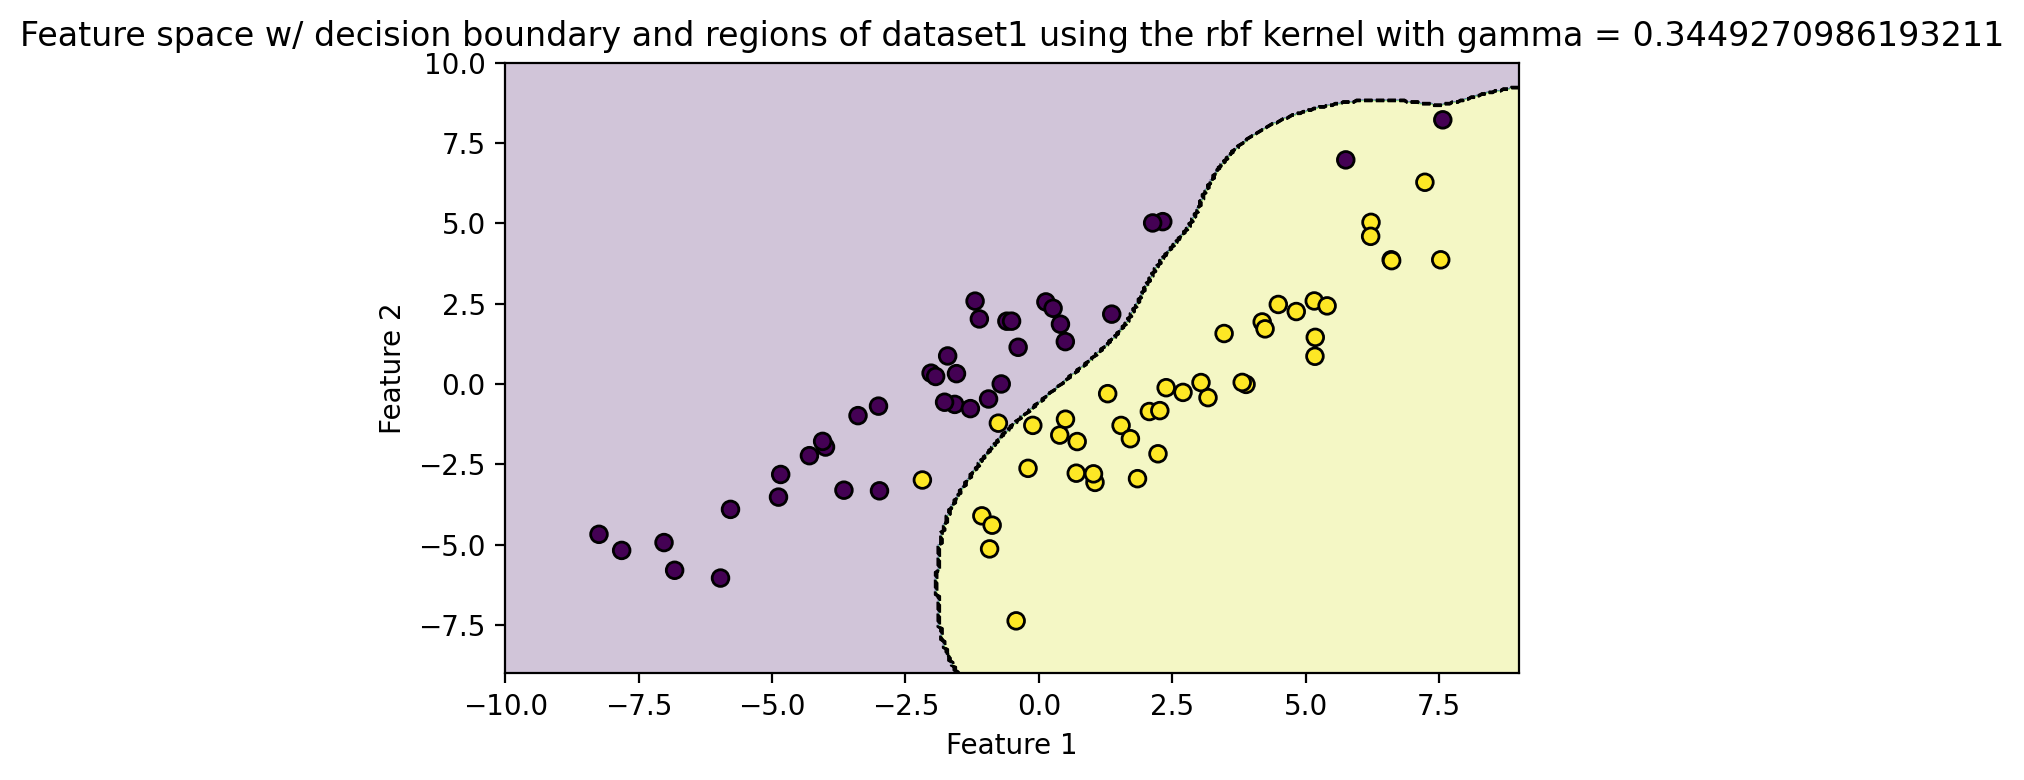

*** Plotting the decision regions for the RBF kernel with gamma = 3.449270986193211 ***


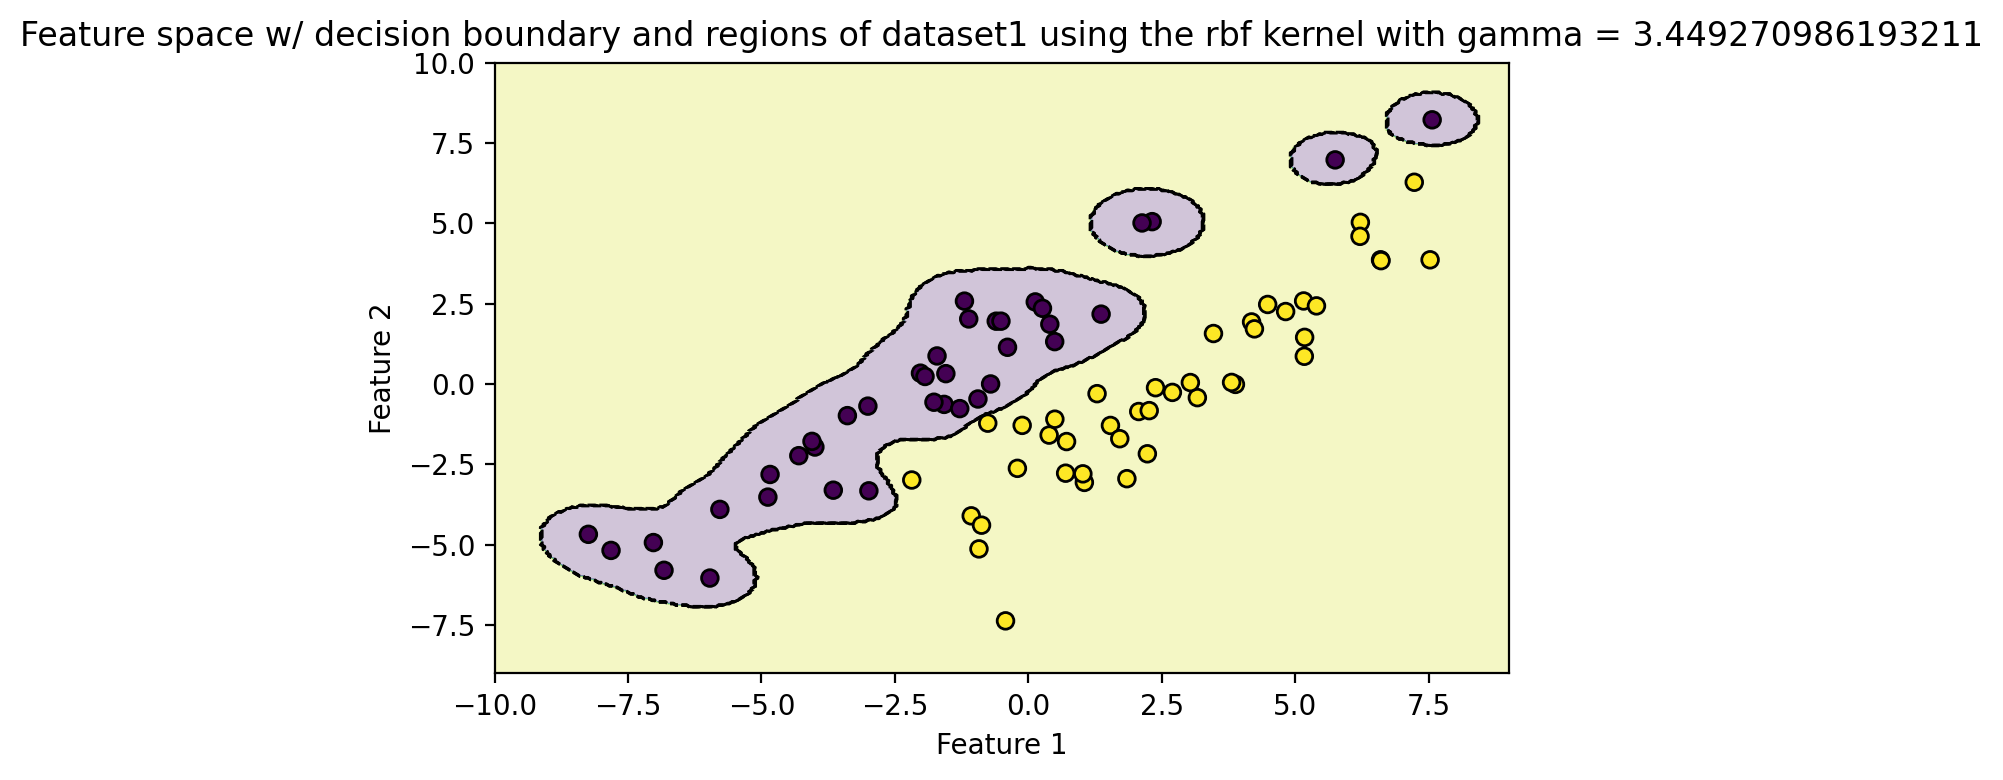

*** Plotting the decision regions for the RBF kernel with gamma = 11.497569953977369 ***


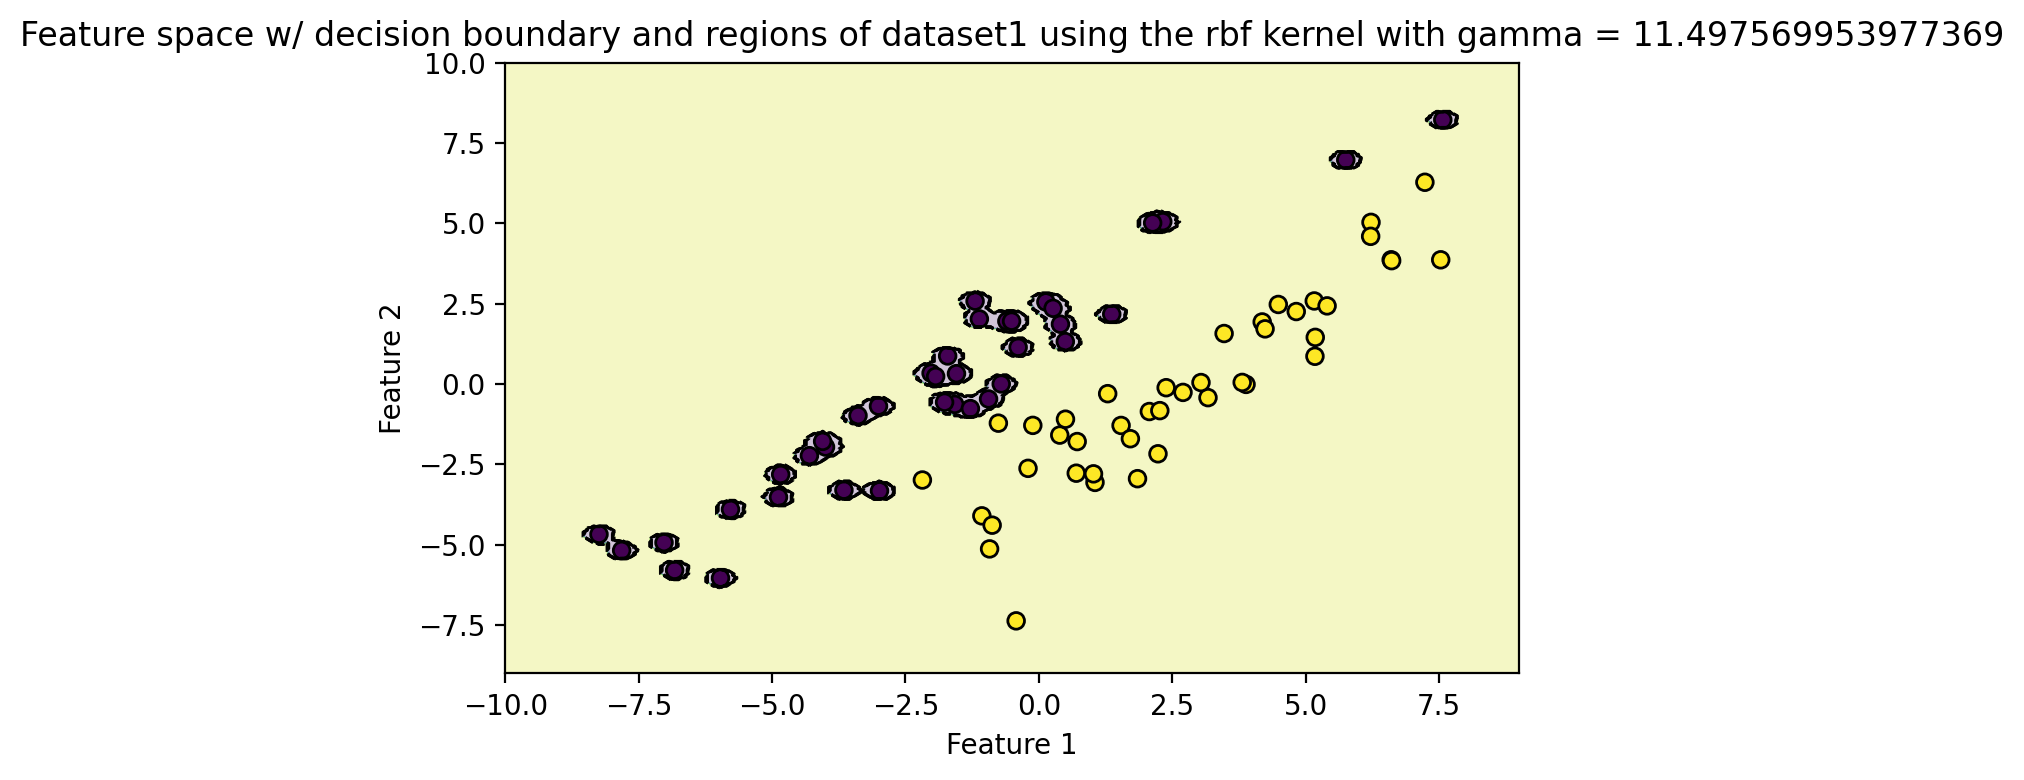

*** Plotting the decision regions for the RBF kernel with gamma = 114.97569953977369 ***


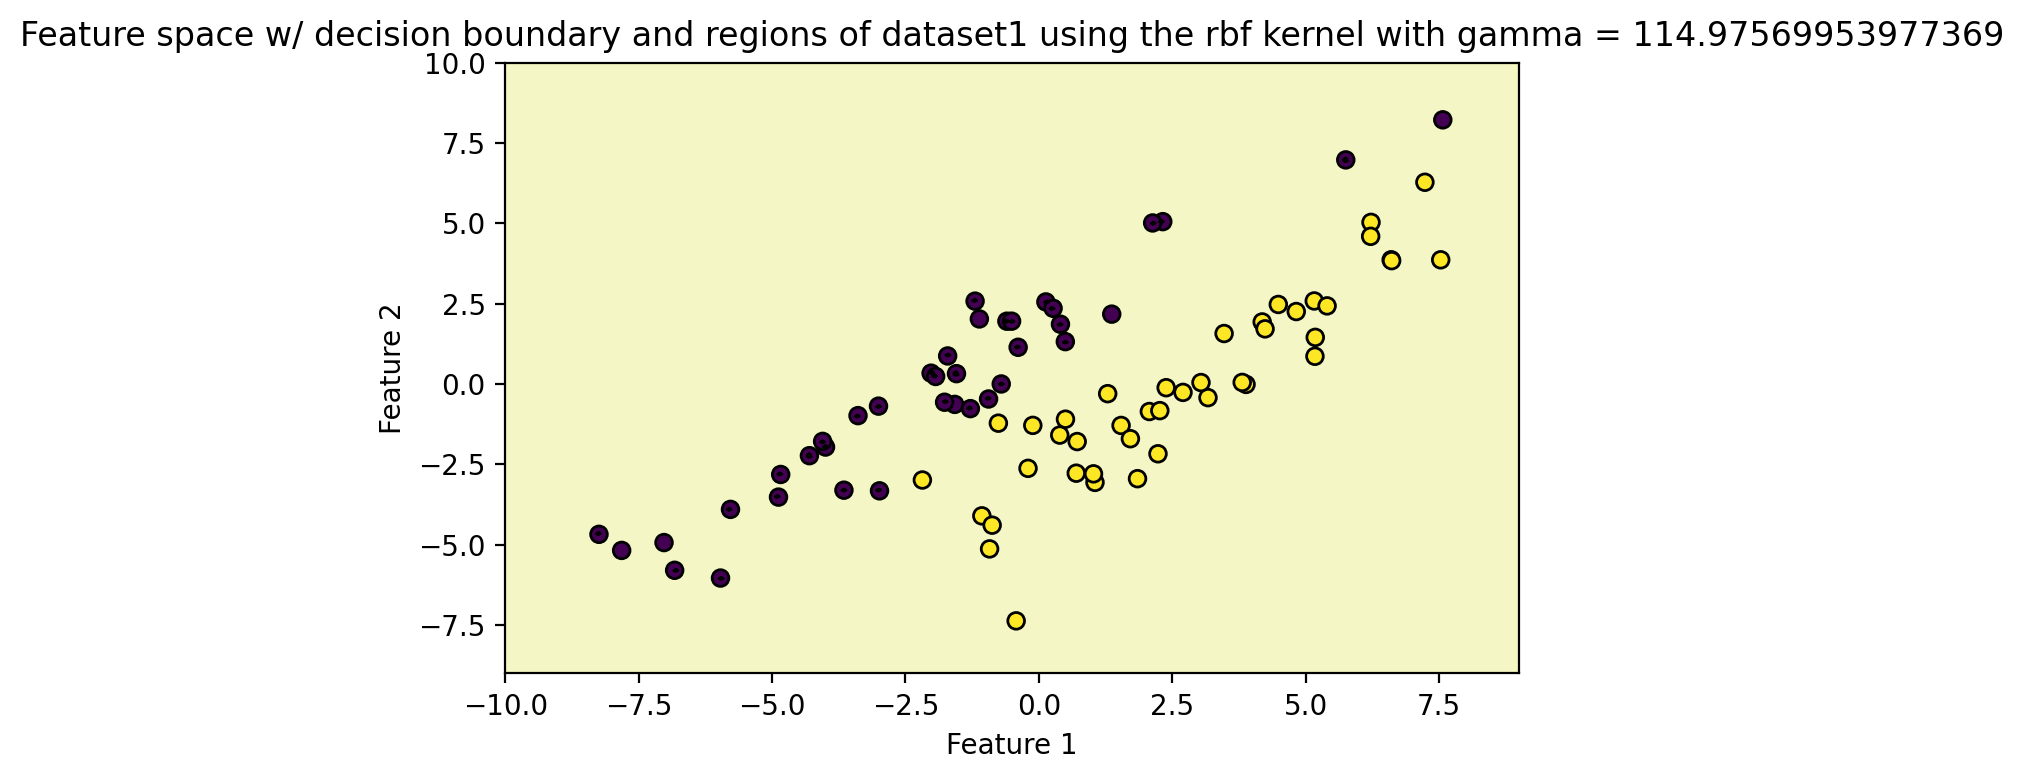

*** DONE RUNNING SCRIPTS FOR dataset1 ***
*** RUNNING SCRIPTS FOR dataset2 ***
Optimal gamma = 3.1992671377973845


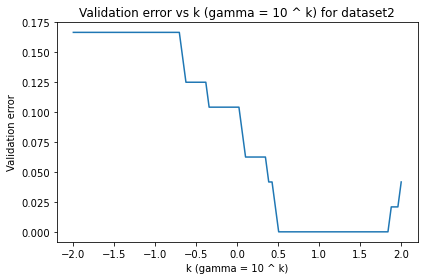

Test set error using the RBF and linear kernels = 0.0125, 0.24375, respectively
*** Plotting the decision regions for the linear kernel ***


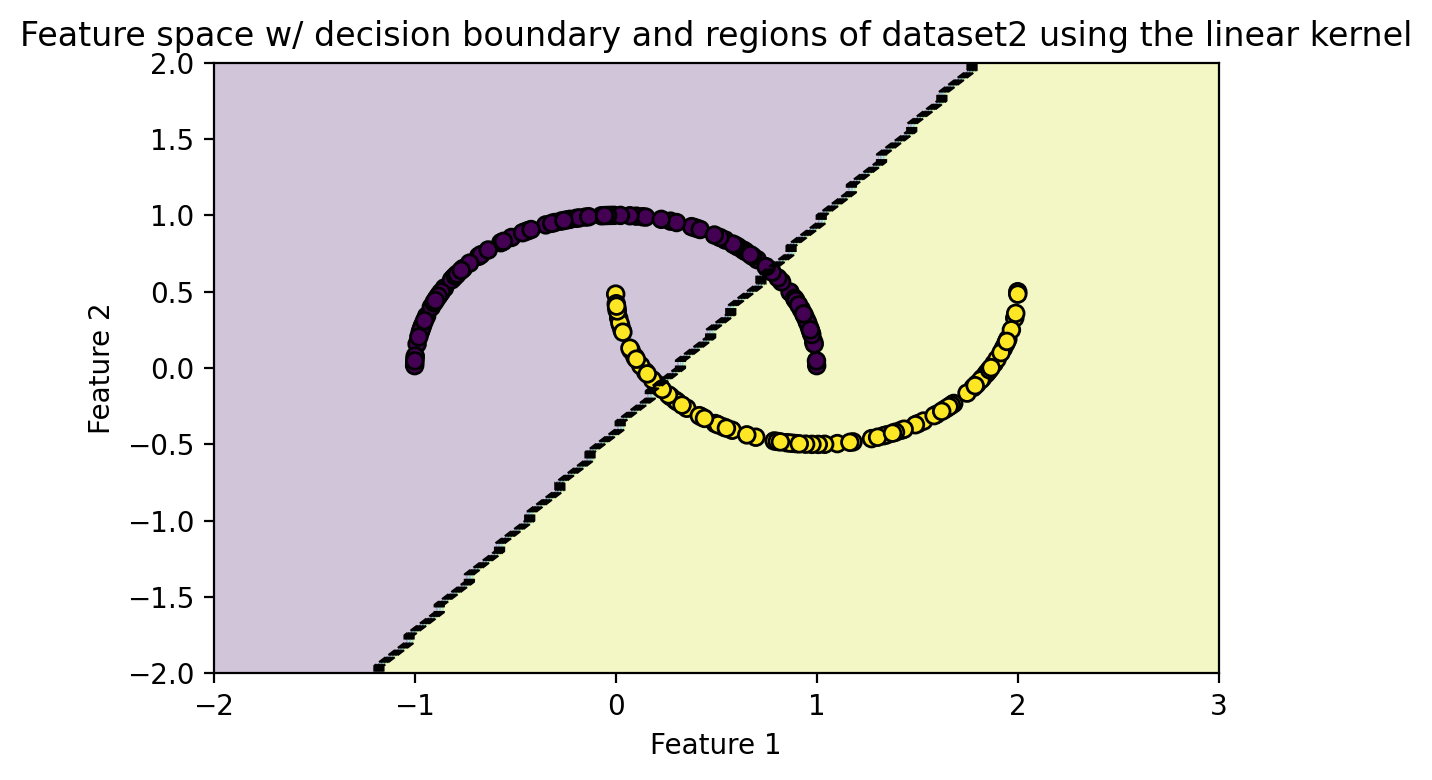

*** Plotting the decision regions for the RBF kernel ***


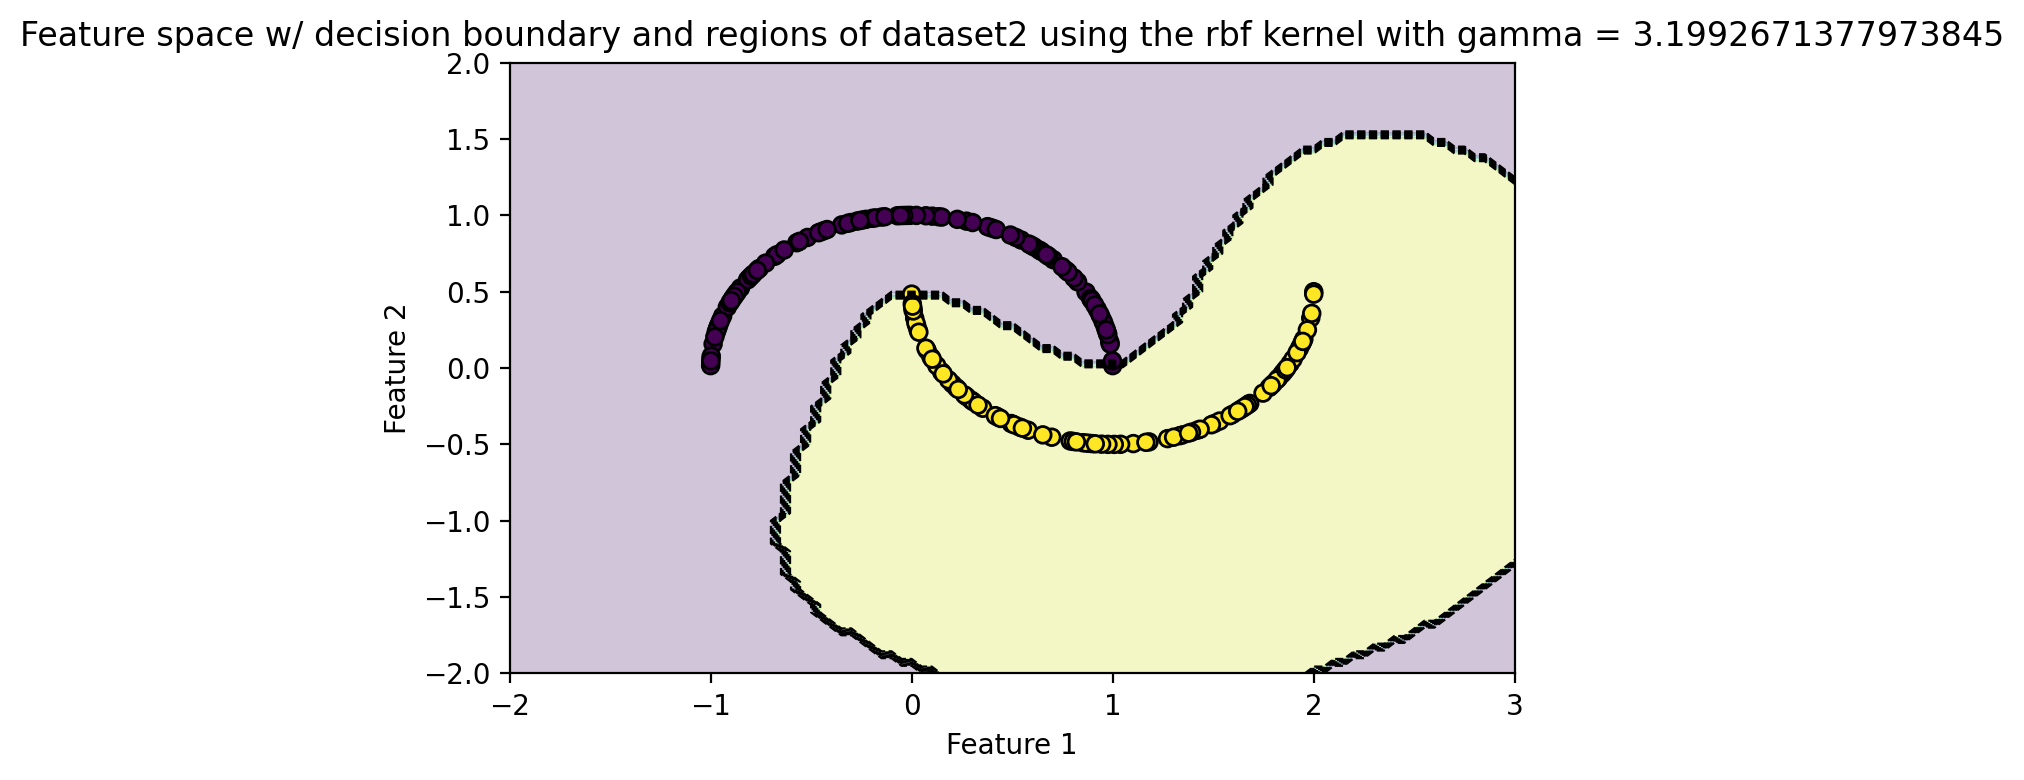

*** Plotting the decision regions for the RBF kernel with gamma = 0.03199267137797385 ***


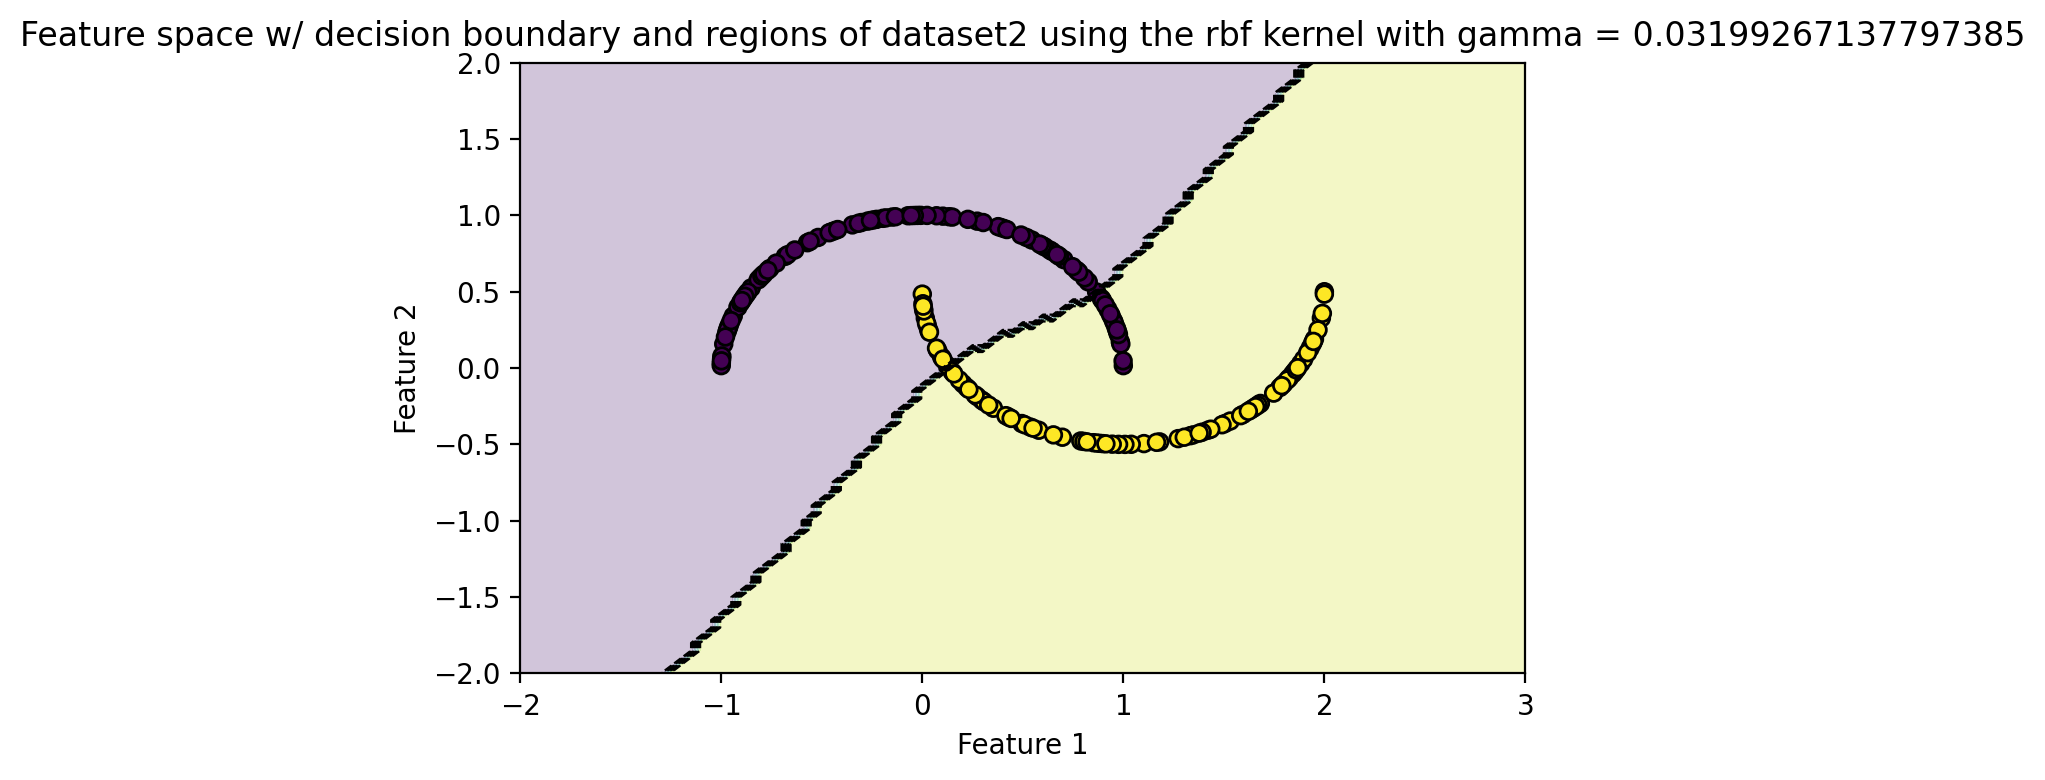

*** Plotting the decision regions for the RBF kernel with gamma = 0.31992671377973847 ***


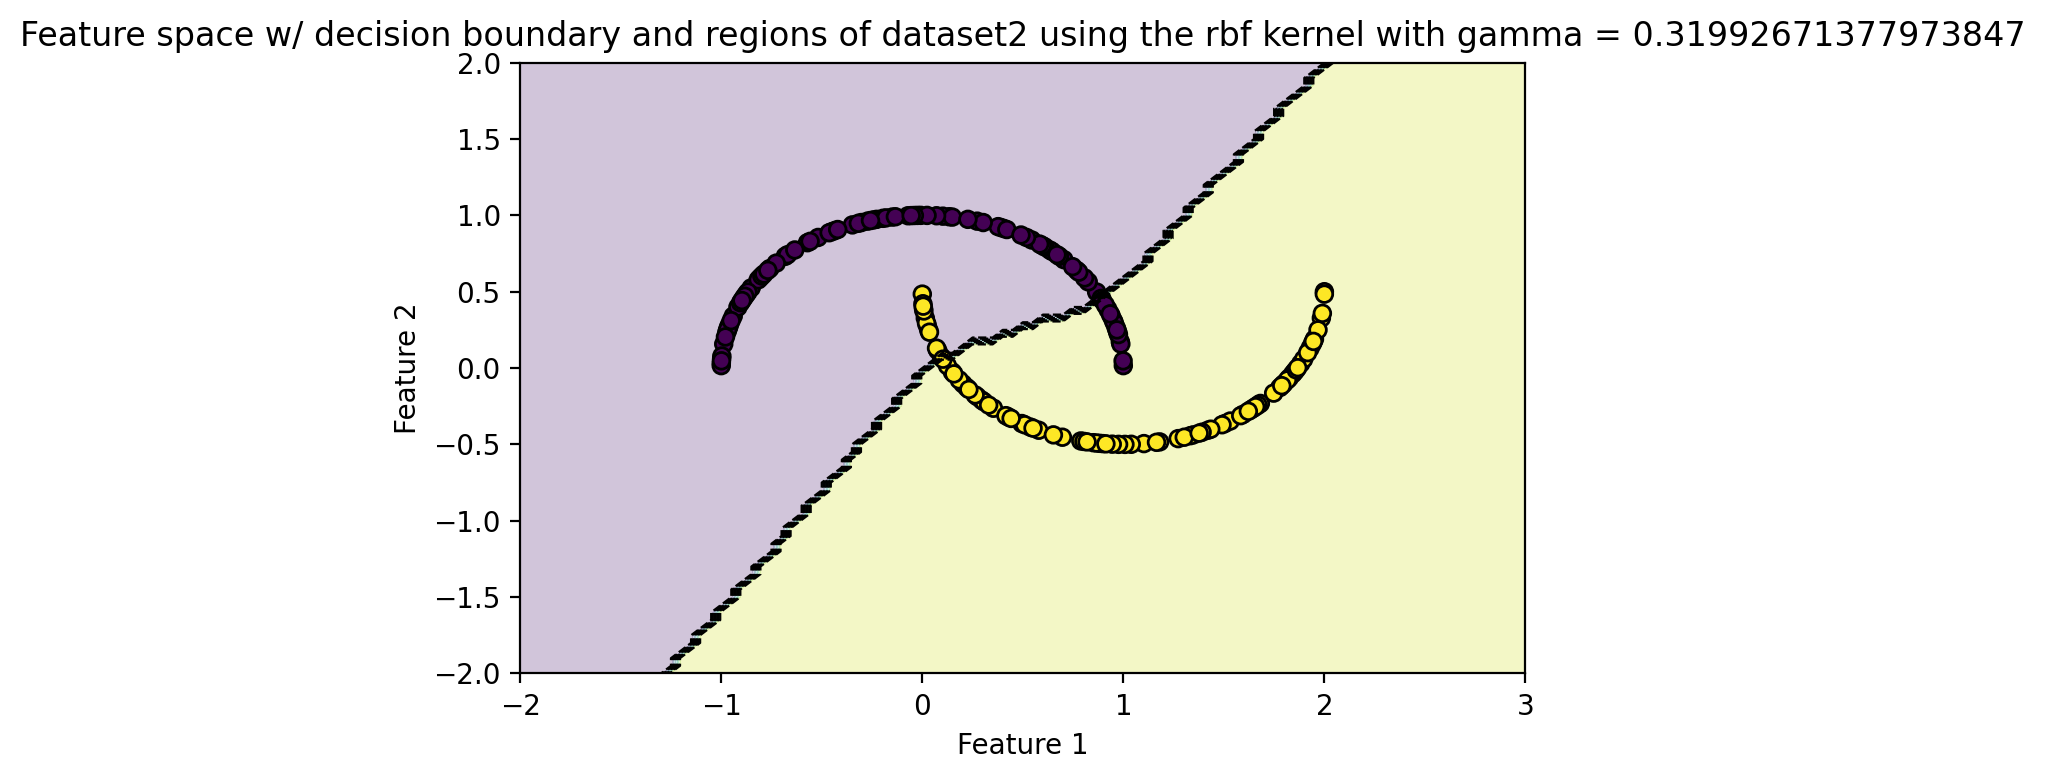

*** Plotting the decision regions for the RBF kernel with gamma = 0.9597801413392153 ***


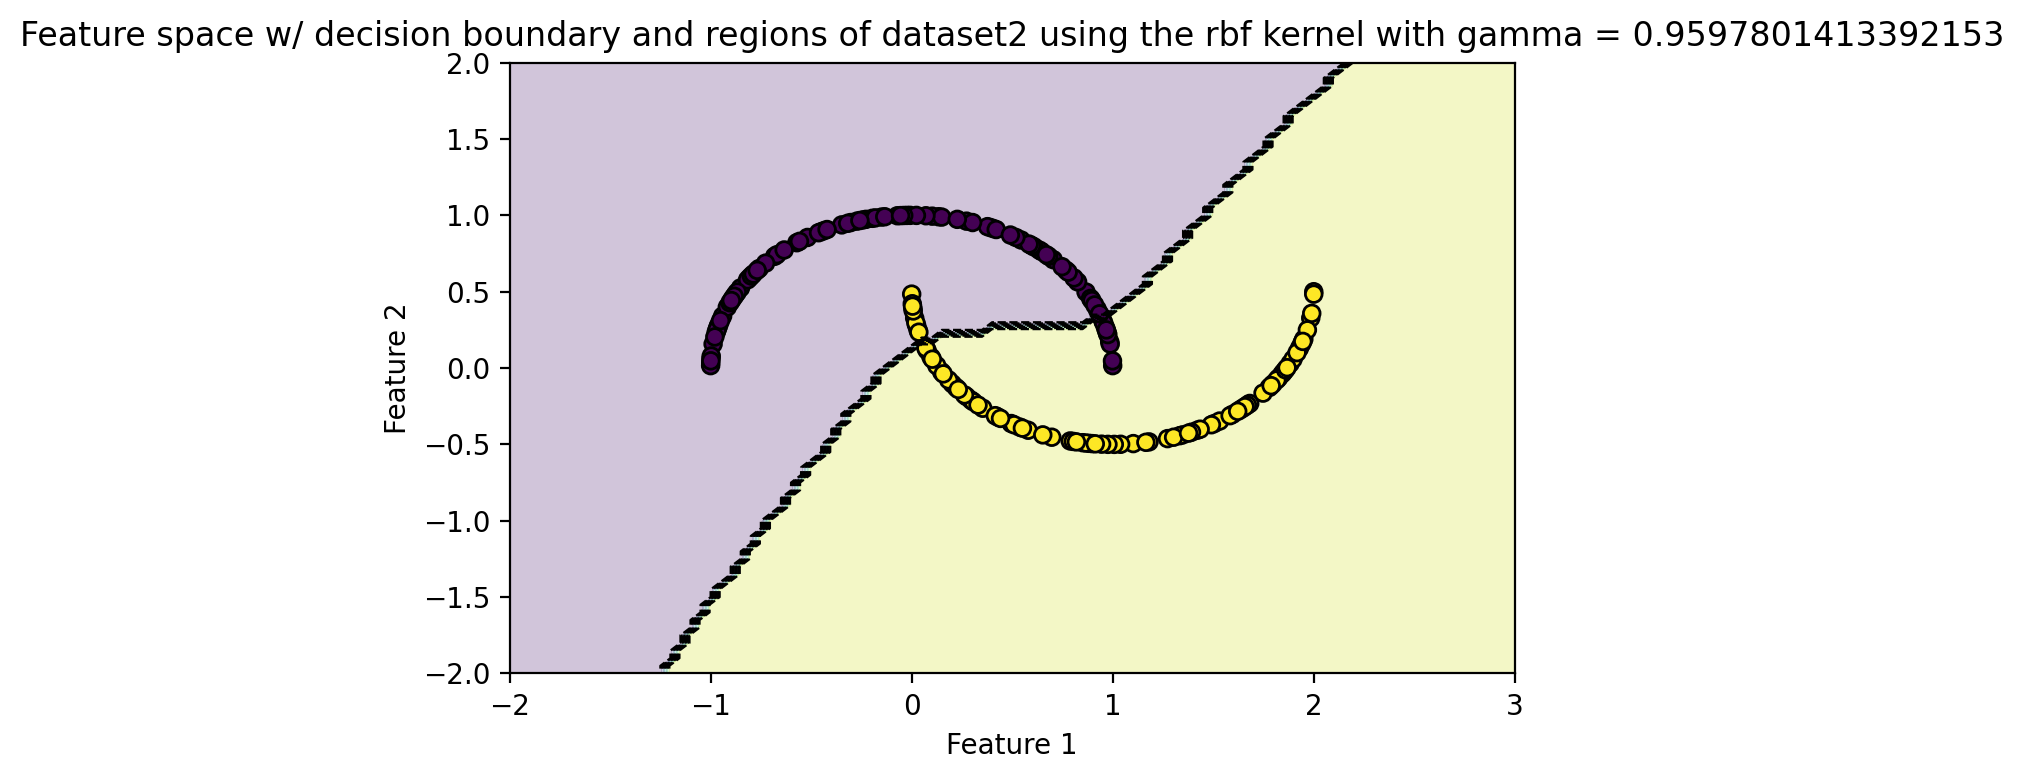

*** Plotting the decision regions for the RBF kernel with gamma = 9.597801413392153 ***


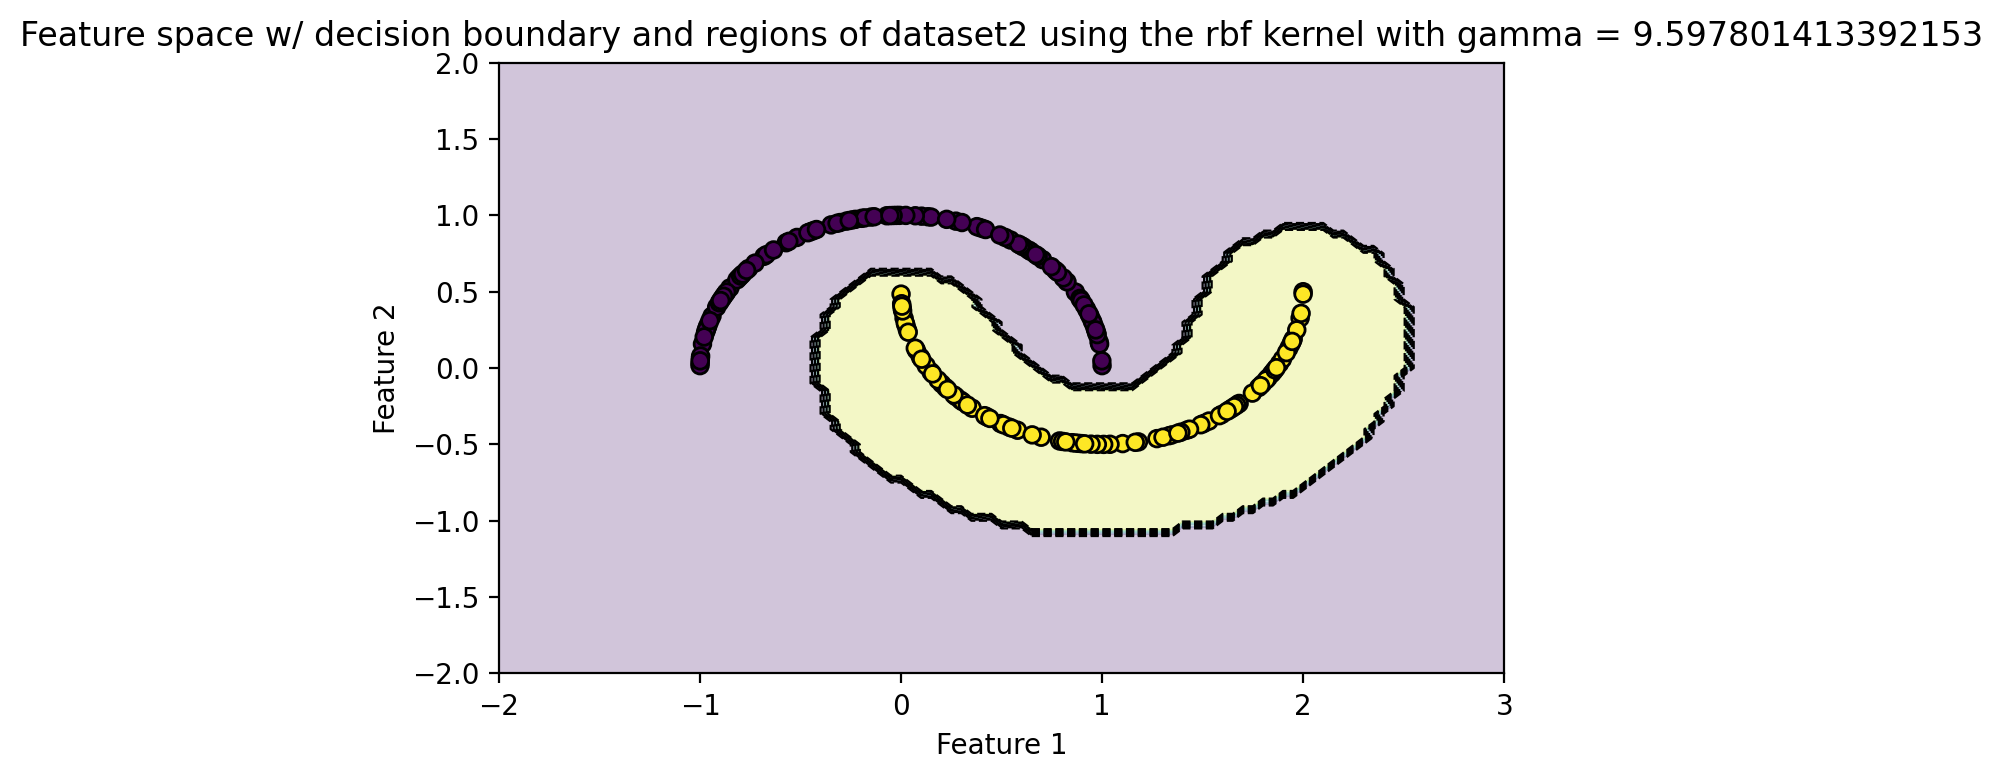

*** Plotting the decision regions for the RBF kernel with gamma = 31.992671377973846 ***


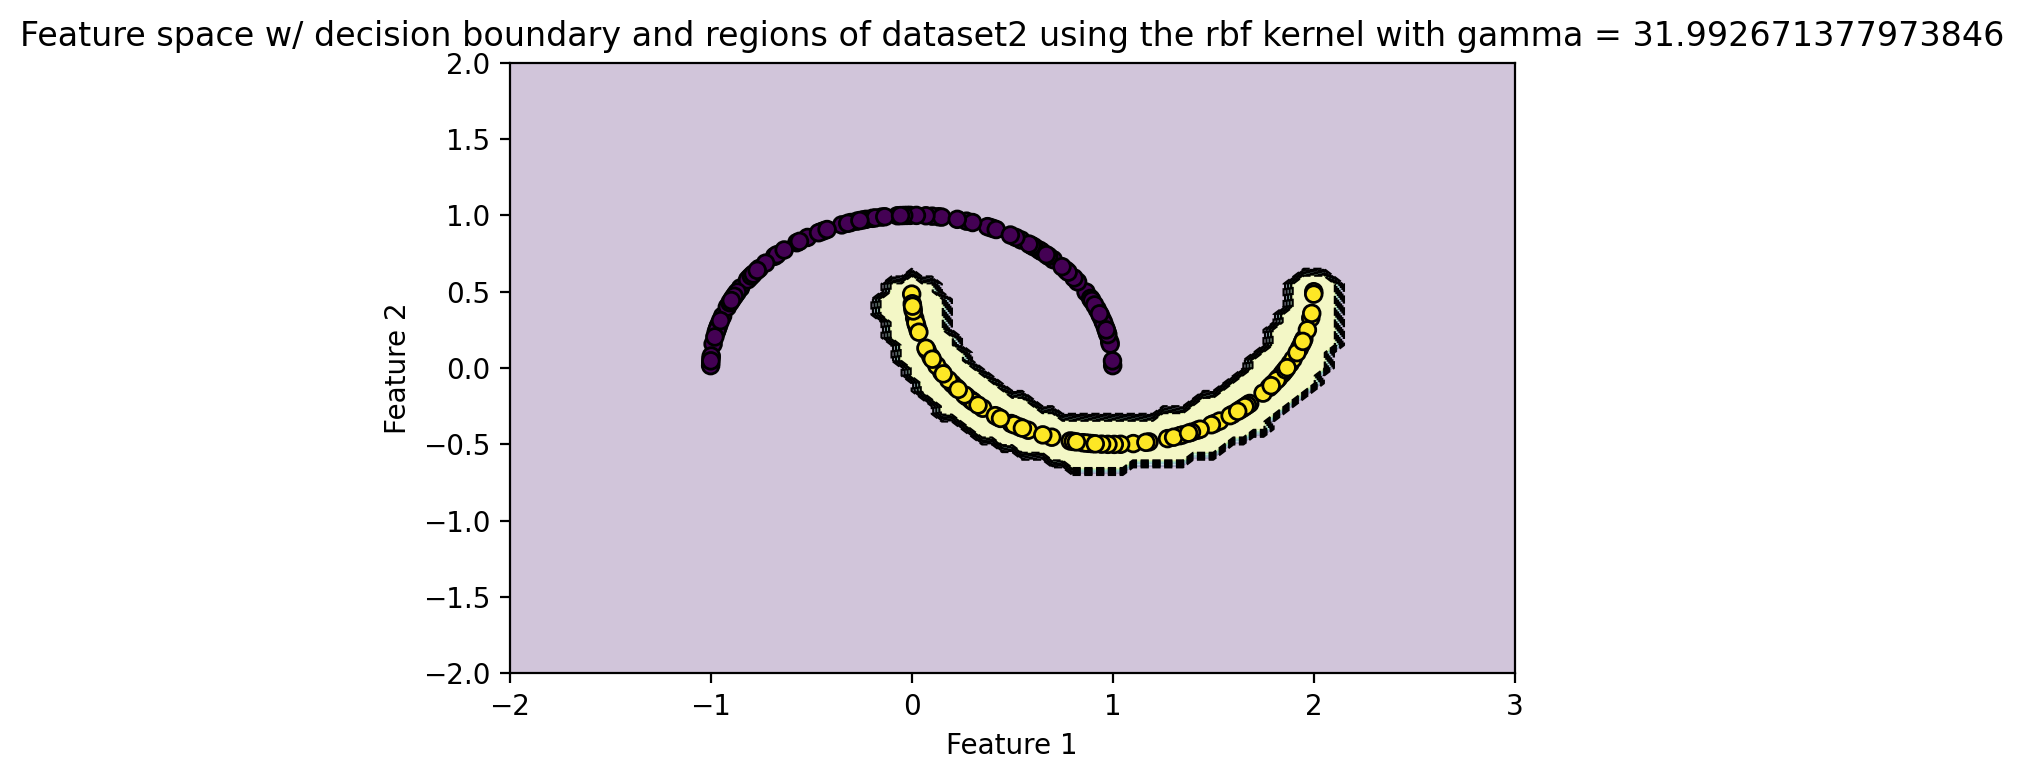

*** Plotting the decision regions for the RBF kernel with gamma = 319.92671377973846 ***


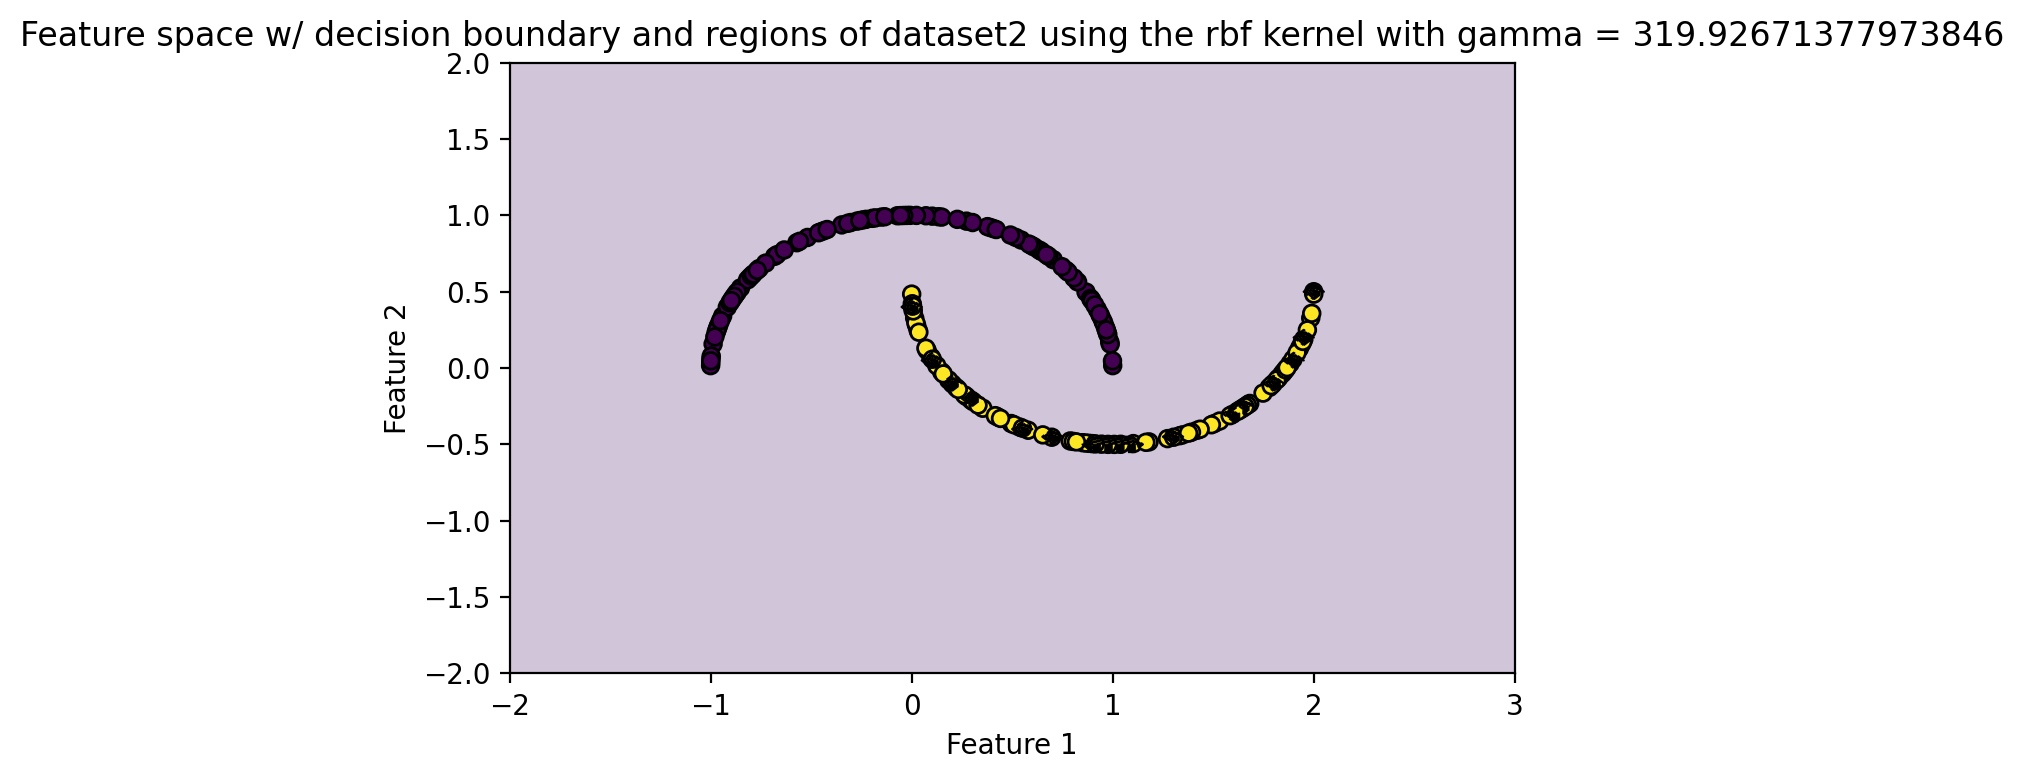

*** DONE RUNNING SCRIPTS FOR dataset2 ***


In [8]:
if __name__ == '__main__':
    root = '/home/sarthak/Desktop/spring_22/EE_559/midterm/data/'
    for idx in range(2):
        if idx == 0:
            ROOTDIR = os.path.join(root, 'Pr1_dataset1/')
            TRAIN_FILE = 'train.csv'
            VAL_FILE = 'val.csv'
            TEST_FILE = 'test.csv'
        else:
            ROOTDIR = os.path.join(root, 'Pr1_dataset2/')
            TRAIN_FILE = 'train_2.csv'
            VAL_FILE = 'val_2.csv'
            TEST_FILE = 'test_2.csv'
        current_dataset = (ROOTDIR.split('/')[-2]).split('_')[1]
        hw = Kernel(ROOTDIR, TRAIN_FILE, TEST_FILE, VAL_FILE, current_dataset)
        hw._runner()